# Enron Email Dataset

## Questions

### Question No. 1
*Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?*

This project is about using machine learning techniques to indetify persons of interest (POIs) in the Enron dataset. "In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives." This data will be used in this project to build a person of interest indentifier.
There were a four outliers of which two are still included in this dataset. The ones removed were TOTAL and TRAVEL AGENCY IN THE PARK, which are both no natural persons. The ones still inclueded are SKILLING JEFFREY K as well as LAY KENNETH L which have very high payments but were in the center of the fraud and should be included. Also there were two parsing mistakes that needed to be fixed.

### Question No. 2
*What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.*

I ended up using all features exept the ones I did in the identifier. While I started the selection process using KBest which effectively selected all features with a p-value below 5% and identified SVC as the best fit algorithm.

| feature                 | score        | pvalue  |
| ----------------------- |------------- | -----   |
| sent_to_poi_ratio	      | 13.433	     | 0.0003  |
| restricted_stock	      | 8.769	     | 0.0036  |
| exercised_stock_options | 6.756	     | 0.0103  |
| recieved_from_poi_ratio | 6.005	     | 0.0155  |
| total_stock_value	      | 5.866        | 0.0167  |
| shared_receipt_with_poi | 5.678        | 0.0185  |
| total_payments	      | 4.872        | 0.0289  |

I played around with a lot of combinations of the top features in the list but ended up using all of the features included in the original dataset to achive precision and recall values above 0.3.
There are three measurable interactions with POIs in the dataset: sending, recieving emails as well as sharing a reciept with a POI. I translated those interactions ratios to be get a metric that is not biased by the total amount of interactions but based on the share of those with POIs as kind of a connectedness metric.


##### Question No. 3
*What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms?*

I ended up using a Support Vector Machine Classifier after trying K-means Clustering and Random Forest as well. I chose those algorithms as they come from three different approches to identify patterns which I wanted to try on the dataset.

| Algorithm     | precision  | recall |
| ------------- | ---------- | ------ |
| KMeans        | 0.025      | 0.147  |
| SVC           | 0.265      | 0.609  |
| Random Forest | 0.312      | 0.160  |


##### Question No. 4
*What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm? What parameters did you tune? (Some algorithms do not have parameters that you need to tune -- if this is the case for the one you picked, identify and briefly explain how you would have done it for the model that was not your final choice or a different model that does utilize parameter tuning, e.g. a decision tree classifier).*

Parameter tuning is about choosing a set of optimal parameters for a learning algorithm. If the parameters are not tuned well the algortihm risks overfitting. 
After chosing SVC as the algorithm to further tune I first played around with the features selected leading to include all original features in the model as those had the highest natural precision & recall. Then I moved on to optimise  parameters gamma (Kernel coefficient) and C (penalty). After reading about them and moving them around to find the optimum I eneded up achiving a precision & recall of over 0.3. 

##### Question No. 5
*What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?*

Validation is about quantifying the performance of an algorithm based on confision matrixs metrics such as precision and recall. The enron dataset includes way more non-POI's than POI's, which needs to be considered when evaluating the classification algos. If an algo such as POI = False would be deployed the accuracy would already be at 86%, but precision at 0%. 
This is why I chose to only optimise on precision and recall as mentioned above.


##### Question No. 6
*Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance.*

The algorithms had the following mean precision and recall values of 1000 iterations:

| Algorithm     | precision  | recall |
| ------------- | ---------- | ------ |
| KMeans        | 0.025      | 0.147  |
| SVC           | 0.265      | 0.609  |
| Random Forest | 0.312      | 0.160  |

When optimising the performance of the SVC algorithm I chose `C=2000` and `gamma=0.0001` which lead to the following:

| Algorithm     | precision  | recall |
| ------------- | ---------- | ------ |
| SVC           | 0.314      | 0.630  |


Precision: How many selected items are relevant?  
Of all indentified POIs there are 31% which actually are POIs while 69% are non-pois.

Recall: How many relevant items are selected?
The model identified 63% of all POIs in the dataset.

##### Outlook

Given the bad precision of only 31% this identifier is mostly wrong in identifying POIs from the Enron dataset. Still with a recall of 69% it is better than guessing. It turnes out that identifying Fraud or Spamm which is based on highly skewed data is very hard. To increase the performance of identification I'd suggest to look for patterns in the text of the emails. Maybe there are certain word combinations that are mostly used by POIs. 
The documentation on Spamm classification which is available could be of great help there as it handles a similar problem: identifying behavioural patterns of a small group of people.

# Note about the notebook
The follwing part is the original analysis I did to come up with the final identifyer that can be found in poi_id.py. The process of finding the right features, algortihm & parameters involved a lot of trial and error, which did not always happen in a linear way. The result is the following notebook, which is an appendix to the identifier but not optimised for readability.

## Initial Load
### Load packages

In [46]:
import sys
import pickle
import numpy as np
from numpy import mean
import pandas as pd
from pandas import DataFrame
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer
from sklearn.ensemble import ExtraTreesClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif, SelectFpr
from sklearn.decomposition import RandomizedPCA
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn import cross_validation
sys.path.append("../tools/")
%matplotlib inline
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

### Load dataset and create dataframe

In [2]:
features_email = ['to_messages', 'from_messages',  'from_poi_to_this_person',
           'from_this_person_to_poi', 'shared_receipt_with_poi']
# finance data
features_finance = ['salary', 'bonus', 'long_term_incentive', 'deferred_income',
             'deferral_payments', 'loan_advances', 'other', 'expenses',
             'director_fees', 'total_payments',
             'exercised_stock_options', 'restricted_stock',
             'restricted_stock_deferred', 'total_stock_value']
# all features
features_list = features_email + features_finance
# all features column names
features_column_names = ['poi'] + ['email_address'] + features_email + features_finance
# all features data type
features_dtype = [bool] + [str] + list(np.repeat(float, 19))

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

# converting the data into a data frame
df = DataFrame.from_dict(data_dict, orient='index')

# reordering the columns
df = df.loc[:, features_column_names]

# converting the data type
for i in xrange(len(features_column_names)):
    df[features_column_names[i]] = df[features_column_names[i]].astype(features_dtype[i], errors='ignore')

## Features
### 1. Exploration
#### Dataset size

In [40]:
#Dataset Shape:
df.shape

(144, 24)

The shape of the dataset shows that there are 144 rows (persons) and 24 columns (features) of which 3 are the interaction with POS ratios that were just added.

#### Outlier investigation
In the follwing the dataset will be investigated for outliers & extreme values. Outliers are defined as values above Q3 + 1.5 IQR, extreme values as those above Q3 + 3 IQR. Those values that can be found will be checked manually to make sure they are not mistakes that happened during the import. Later some outliers will be removed to test if this increases the accuracy of the algorithm. Given that most of the POIs had extremely high salary and bonus payments, removing those outliers might acutally hurt the outcome of the algorithm.

In [4]:
df.describe()

,to_messages,from_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value
count,86.000000,86.000000,86.000000,86.000000,86.000000,9.500000e+01,8.200000e+01,6.600000e+01,4.900000e+01,3.900000e+01,4.000000e+00,9.300000e+01,9.500000e+01,1.700000e+01,1.250000e+02,1.020000e+02,1.100000e+02,1.800000e+01,1.260000e+02
mean,2073.860465,608.790698,64.895349,41.232558,1176.465116,5.621943e+05,2.374235e+06,1.470361e+06,-1.140475e+06,1.642674e+06,4.196250e+07,9.190650e+05,1.087289e+05,1.668049e+05,5.081526e+06,5.987054e+06,2.321741e+06,1.664106e+05,6.773957e+06
std,2582.700981,1841.033949,86.979244,100.073111,1178.317641,2.716369e+06,1.071333e+07,5.942759e+06,4.025406e+06,5.161930e+06,4.708321e+07,4.589253e+06,5.335348e+05,3.198914e+05,2.906172e+07,3.106201e+07,1.251828e+07,4.201494e+06,3.895777e+07
min,57.000000,12.000000,0.000000,0.000000,2.000000,4.770000e+02,7.000000e+04,6.922300e+04,-2.799289e+07,-1.025000e+05,4.000000e+05,2.000000e+00,1.480000e+02,3.285000e+03,1.480000e+02,3.285000e+03,-2.604490e+06,-7.576788e+06,-4.409300e+04
25%,541.250000,22.750000,10.000000,1.000000,249.750000,2.118160e+05,4.312500e+05,2.812500e+05,-6.948620e+05,8.157300e+04,1.600000e+06,1.215000e+03,2.261400e+04,9.878400e+04,3.944750e+05,5.278862e+05,2.540180e+05,-3.896218e+05,4.945102e+05
50%,1211.000000,41.000000,35.000000,8.000000,740.500000,2.599960e+05,7.693750e+05,4.420350e+05,-1.597920e+05,2.274490e+05,4.176250e+07,5.238200e+04,4.695000e+04,1.085790e+05,1.101393e+06,1.310814e+06,4.517400e+05,-1.469750e+05,1.102872e+06
75%,2634.750000,145.500000,72.250000,24.750000,1888.250000,3.121170e+05,1.200000e+06,9.386720e+05,-3.834600e+04,1.002672e+06,8.212500e+07,3.620960e+05,7.995250e+04,1.137840e+05,2.093263e+06,2.547724e+06,1.002370e+06,-7.500975e+04,2.949847e+06
max,15149.000000,14368.000000,528.000000,609.000000,5521.000000,2.670423e+07,9.734362e+07,4.852193e+07,-8.330000e+02,3.208340e+07,8.392500e+07,4.266759e+07,5.235198e+06,1.398517e+06,3.098866e+08,3.117640e+08,1.303223e+08,1.545629e+07,4.345095e+08


In [5]:
# change for each feature to avoid repetitive code blocks
current_feature = 'restricted_stock'

(array([ 107.,    2.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    1.]),
 array([ -2.60449000e+06,   1.06881889e+07,   2.39808678e+07,
          3.72735467e+07,   5.05662256e+07,   6.38589045e+07,
          7.71515834e+07,   9.04442623e+07,   1.03736941e+08,
          1.17029620e+08,   1.30322299e+08]),
 <a list of 10 Patch objects>)

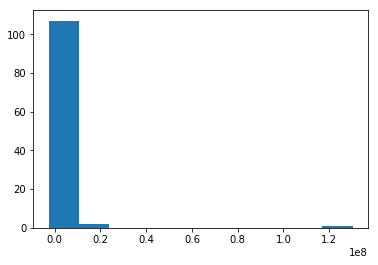

In [6]:
plt.hist(df[current_feature].dropna())

In [7]:
q75, q25 = np.percentile(df[current_feature].dropna(), [75 ,25])
iqr = q75 - q25

# negative outliers:
df[df[current_feature] < q25 - (iqr*1.5)] 
# positive outliers:
#df[df[current_feature] > q75 + (iqr*1.5)][current_feature]

,poi,email_address,to_messages,from_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi,salary,bonus,long_term_incentive,...,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value
BHATNAGAR SANJAY,False,sanjay.bhatnagar@enron.com,523.0,29.0,0.0,1.0,463.0,NaN,NaN,NaN,...,NaN,NaN,137864.0,NaN,137864.0,15456290.0,2604490.0,-2604490.0,15456290.0,NaN


#### Cleaning
##### Fix & remove invalid columns

`TOTAL`: aggregation of the existing datapoints and does not represent a person -> removed

`THE TRAVEL AGENCY IN THE PARK`: not a real person -> removed

`BHATNAGAR SANJAY`: columns shifted one to the left -> fixed

`BELFER ROBERT`: columns shifted one to the left -> fixed

In [8]:
df = df[df.index != 'TOTAL']
df = df[df.index != 'THE TRAVEL AGENCY IN THE PARK']

df.loc['BELFER ROBERT', features_finance] = \
    [0, 0, 0, -102500, 0, 0, 0, 3285,
     102500, 3285, 0, 44093, -44093, 0]
df.loc['BHATNAGAR SANJAY', features_finance] = \
    [0, 0, 0, 0, 0, 0, 0, 137864, 0, 137864,
     15456290, 2604490, -2604490, 15456290]

###### Log scaling

While plotting the histograms of the features the highly skewed distribution of most of the features could be observed. As some models perform better or even require a normal distribution I applied log scaling to the features.
The log scaling can easily be reverted using the exponential function no information is lost.

In [9]:
for f in features_list:
    df[f] = [np.log(abs(v)) if v != 0 else 0 for v in df[f]]

#### Missing values
Check for missing values per feature and compare the ratio of poi's within those.

In [10]:
df_null_value_ratio = (df.isnull().sum() / df.shape[0]).sort_values(ascending=False)
df_null_values = (df.isnull().sum()).sort_values(ascending=False)
frames = [df_null_values, df_null_value_ratio]
pd.concat(frames, axis=1, join_axes=[df_null_values.index])

,0,1
loan_advances,139,0.965278
director_fees,128,0.888889
restricted_stock_deferred,127,0.881944
deferral_payments,105,0.729167
deferred_income,94,0.652778
long_term_incentive,77,0.534722
bonus,61,0.423611
to_messages,58,0.402778
shared_receipt_with_poi,58,0.402778
from_this_person_to_poi,58,0.402778


In [11]:
# count number of pois
print 'Number of POIs:'
df.loc[df['poi'] == True].count().sort_values()

Number of POIs:


restricted_stock_deferred     0
director_fees                 0
loan_advances                 1
deferral_payments             5
deferred_income              11
long_term_incentive          12
exercised_stock_options      12
to_messages                  14
from_messages                14
from_poi_to_this_person      14
from_this_person_to_poi      14
shared_receipt_with_poi      14
bonus                        16
restricted_stock             17
salary                       17
total_payments               18
poi                          18
other                        18
email_address                18
expenses                     18
total_stock_value            18
dtype: int64

In [12]:
df_non_null_values = (df.notnull().sum()).sort_values(ascending=False)
df_number_pois = df.loc[df['poi'] == True].count().sort_values()
(df_number_pois/df_non_null_values).sort_values(ascending=False)

deferred_income              0.220000
loan_advances                0.200000
other                        0.195652
bonus                        0.192771
expenses                     0.187500
long_term_incentive          0.179104
salary                       0.177083
from_this_person_to_poi      0.162791
to_messages                  0.162791
from_messages                0.162791
from_poi_to_this_person      0.162791
shared_receipt_with_poi      0.162791
restricted_stock             0.154545
total_payments               0.146341
total_stock_value            0.142857
deferral_payments            0.128205
poi                          0.125000
email_address                0.125000
exercised_stock_options      0.118812
restricted_stock_deferred    0.000000
director_fees                0.000000
dtype: float64

Given that we only have very small sets of data for restricted_stock_deferred, director_fees, loan_advances and deferral_payments. Given that POI's only make up for 12.5% of our dataset the ratio of pois is higher than average in the bonus and expense categories.

We got dataset that includes way more non-POI's than POI's, which needs to be considered when evaluating the classification algos. If an algo such as POI = False would be deployed the accuracy would already be at 86%, but precision at 0%.

### 2. Creation - Ratio of email & receipt sharing with pois

There are three measurable interactions with POIs in the dataset: sending, recieving emails as well as sharing a reciept with a POI. Those interactions should be translated into ratios that compare them with the total number of each type of interaction.

In [13]:
# calculate ratio
df['recieved_from_poi_ratio'] = df['from_poi_to_this_person'] / df['to_messages']
df['sent_to_poi_ratio'] = df['from_this_person_to_poi'] / df['from_messages']
df['shared_receipt_with_poi_ratio'] = df['shared_receipt_with_poi'] / df['to_messages']
# add labels to df
features_email_new = ['recieved_from_poi_ratio', 'sent_to_poi_ratio', 'shared_receipt_with_poi_ratio']
features_all = features_list + features_email_new

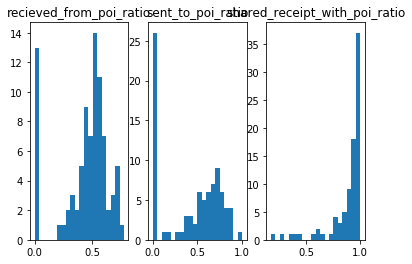

In [14]:
for i in xrange(len(features_email_new)):
    plt.subplot(1, 3, i+1)
    plt.hist(df[features_email_new[i]].dropna(), bins=20)
    plt.title(features_email_new[i])

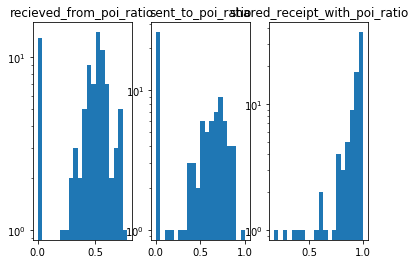

In [15]:
for i in xrange(len(features_email_new)):
    plt.subplot(1, 3, i+1)
    plt.hist(df[features_email_new[i]].dropna(), bins=20, log=True)
    plt.title(features_email_new[i])

The newly introduced mail features are normal distributed while the reciept ratio is highly skewed. Given that log scaling won't change those distributions I will leave them as they are. 

#### Inspect for correlations

In [16]:
df.corr().sort_values('poi', ascending=False)

,poi,to_messages,from_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi,salary,bonus,long_term_incentive,deferred_income,...,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,recieved_from_poi_ratio,sent_to_poi_ratio,shared_receipt_with_poi_ratio
poi,1.000000,0.175735,-0.030703,0.283631,0.250557,0.249806,0.141535,0.197325,0.178831,0.127677,...,0.154566,NaN,0.199331,0.258250,0.241272,NaN,0.200356,0.268978,0.381296,0.207771
loan_advances,0.594422,0.866321,0.147973,0.868089,0.746672,0.821092,0.978356,0.994526,0.992762,0.662663,...,0.444380,NaN,0.926066,0.529966,0.744640,NaN,0.541825,0.887988,0.745410,-0.546226
sent_to_poi_ratio,0.381296,0.386556,0.287242,0.577622,0.822639,0.553221,0.274177,0.330873,0.288014,0.314132,...,-0.087045,NaN,0.223495,0.170572,0.200163,-0.590945,0.230789,0.556570,1.000000,0.514750
from_poi_to_this_person,0.283631,0.695648,0.467432,1.000000,0.656250,0.790229,0.294329,0.508555,0.415545,0.467593,...,0.225109,NaN,0.367184,0.182491,0.156019,-0.593985,0.160717,0.952080,0.577622,0.585973
recieved_from_poi_ratio,0.268978,0.479495,0.284480,0.952080,0.530999,0.672057,0.270776,0.459508,0.405775,0.456687,...,0.196485,NaN,0.286034,0.149921,0.124069,-0.610060,0.143144,1.000000,0.556570,0.627865
exercised_stock_options,0.258250,0.171676,0.068198,0.182491,0.144835,0.202615,0.403502,0.483443,0.539093,0.087354,...,0.255901,-0.477854,0.425899,1.000000,0.592785,0.569163,0.968981,0.149921,0.170572,0.149126
from_this_person_to_poi,0.250557,0.640020,0.748959,0.656250,1.000000,0.621813,0.239732,0.354382,0.262824,0.383049,...,0.025050,NaN,0.293601,0.144835,0.133234,-0.578358,0.179757,0.530999,0.822639,0.366654
shared_receipt_with_poi,0.249806,0.841286,0.481801,0.790229,0.621813,1.000000,0.150722,0.329240,0.206498,0.313485,...,0.352668,-1.000000,0.368433,0.202615,0.317893,-0.123954,0.260651,0.672057,0.553221,0.811061
restricted_stock,0.241272,0.197809,0.019529,0.156019,0.133234,0.317893,0.134248,0.189751,0.223843,0.054193,...,0.155870,-0.997225,0.277651,0.592785,1.000000,0.915837,0.683630,0.124069,0.200163,0.332628
shared_receipt_with_poi_ratio,0.207771,0.388692,0.105712,0.585973,0.366654,0.811061,-0.078216,0.029784,-0.011643,0.141458,...,0.372803,-1.000000,0.201699,0.149126,0.332628,0.786456,0.273288,0.627865,0.514750,1.000000


(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
         18.5,  19.5,  20.5,  21.5,  22.5]),
 <a list of 23 Text yticklabel objects>)

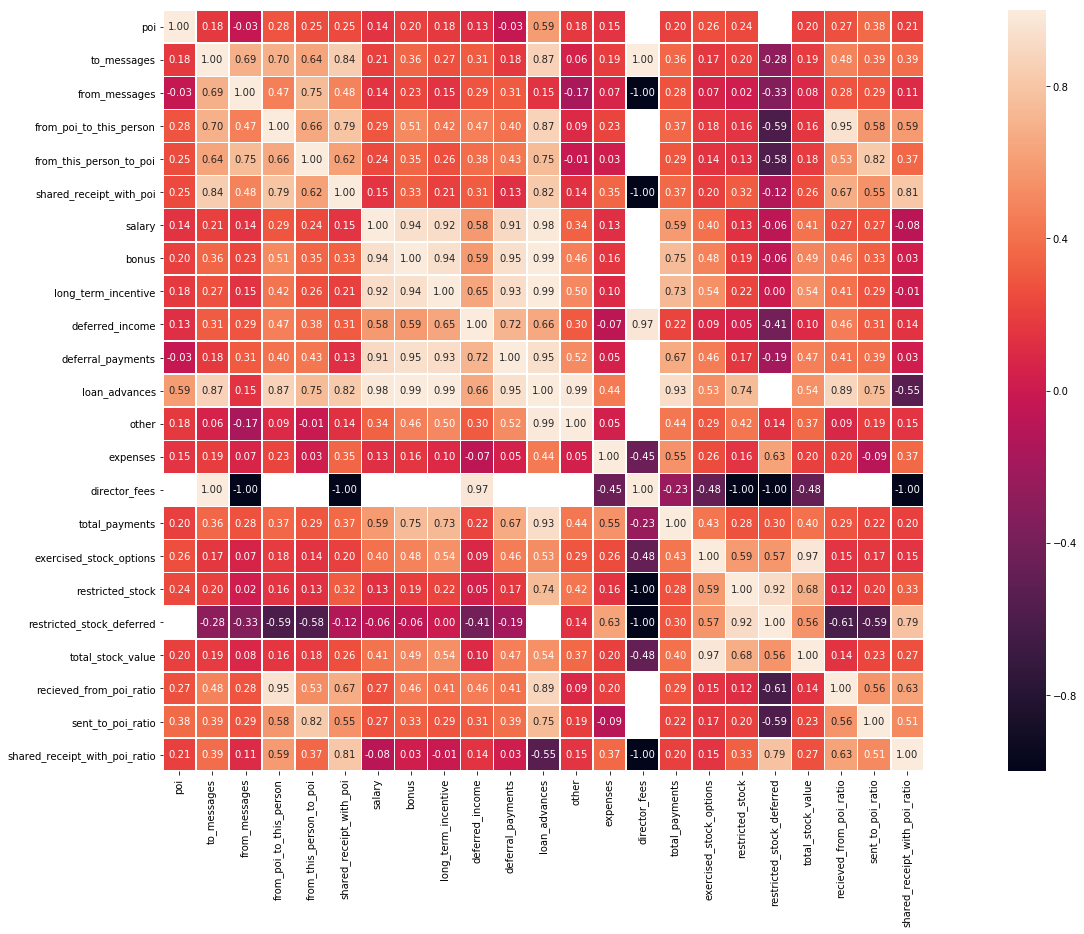

In [17]:
plt.figure(figsize = (30,14))
sns.heatmap(df.corr(), square=True, annot=True, fmt='.2f', linewidths=.5)
plt.xticks(rotation=90)
plt.yticks(rotation=0)

Even though loan advances has a very high correlation, given the percentage of missing values (97%) that feature won't be considered.
The high correlation between the ratios and the absolute numbers of the email and receipt features are expected and when working on the best feature selection it should be evaluated which of those (number or ratio) should be considered. Using both would add the same feature twice.

### 5. Selection
#### KBest

In [18]:
kbest = SelectKBest(f_classif, k='all')
kbest.fit(Imputer(strategy='median').fit_transform(df[features_all]), df['poi'])
features = [(f, round(s, 3), round(p, 4))
            for f, s, p in zip(features_all, kbest.scores_, kbest.pvalues_)]
features = DataFrame.from_records(features, index='feature',
                                  columns=['feature', 'score', 'pvalue'])
features.sort_values(by='score', ascending=False, inplace=True)
features

,score,pvalue
feature,,
sent_to_poi_ratio,13.433,0.0003
restricted_stock,8.769,0.0036
from_poi_to_this_person,7.488,0.0070
from_this_person_to_poi,6.993,0.0091
exercised_stock_options,6.756,0.0103
recieved_from_poi_ratio,6.005,0.0155
total_stock_value,5.866,0.0167
shared_receipt_with_poi,5.678,0.0185
total_payments,4.872,0.0289


In [19]:
fpr = SelectFpr(f_classif, alpha=0.05)
fpr.fit(Imputer(strategy='median').fit_transform(df[features_all]), df['poi'])
features = [(f, round(s, 3), round(p, 4))
            for f, s, p in zip(features_all, fpr.scores_, fpr.pvalues_)
            if p < 0.05]
features = DataFrame.from_records(features, index='feature',
                                  columns=['feature', 'score', 'pvalue'])
features.sort_values(by='score', ascending=False, inplace=True)
features

,score,pvalue
feature,,
sent_to_poi_ratio,13.433,0.0003
restricted_stock,8.769,0.0036
from_poi_to_this_person,7.488,0.0070
from_this_person_to_poi,6.993,0.0091
exercised_stock_options,6.756,0.0103
recieved_from_poi_ratio,6.005,0.0155
total_stock_value,5.866,0.0167
shared_receipt_with_poi,5.678,0.0185
total_payments,4.872,0.0289


"Select the pvalues below alpha based on a FPR test. FPR test stands for False Positive Rate test. It controls the total amount of false detections." (sklearn docs)

Turns out that the FPR test returns the same values that would have been selected when applying the A/B testing industry standart of 5%. After removing the duplications caused by adding the ratios those are the selected features sorted by importance:

| feature                 | score        | pvalue  |
| ----------------------- |------------- | -----   |
| sent_to_poi_ratio	      | 13.433	     | 0.0003  |
| restricted_stock	      | 8.769	     | 0.0036  |
| exercised_stock_options | 6.756	     | 0.0103  |
| recieved_from_poi_ratio | 6.005	     | 0.0155  |
| total_stock_value	      | 5.866        | 0.0167  |
| shared_receipt_with_poi | 5.678        | 0.0185  |
| total_payments	      | 4.872        | 0.0289  |

##### Get sklearn ready dataset

In [45]:
# from sklearn import preprocessing
# scaler = preprocessing.MinMaxScaler()
# features = scaler.fit_transform(features)
# print(df.isnull().sum())
df.replace(0, np.NaN)
df.fillna(df.mean(), inplace=True)


# Get dictionary
my_dataset = df.to_dict(orient='index')
# print my_dataset

#Select the labels
my_feature_list = ['poi'] + features_email + features_finance
# my_feature_list = ['poi'] + ['sent_to_poi_ratio'] + ['restricted_stock'] + ['exercised_stock_options'] + ['from_poi_to_this_person'] + ['shared_receipt_with_poi'] + ['bonus'] + ['long_term_incentive']
# print my_feature_list[1]


# Format and splot to labels and features
data = featureFormat(my_dataset, my_feature_list, remove_NaN=True, sort_keys = False)
labels, features = targetFeatureSplit(data)

print df.count()


poi                              144
email_address                    144
to_messages                      144
from_messages                    144
from_poi_to_this_person          144
from_this_person_to_poi          144
shared_receipt_with_poi          144
salary                           144
bonus                            144
long_term_incentive              144
deferred_income                  144
deferral_payments                144
loan_advances                    144
other                            144
expenses                         144
director_fees                    144
total_payments                   144
exercised_stock_options          144
restricted_stock                 144
restricted_stock_deferred        144
total_stock_value                144
recieved_from_poi_ratio          144
sent_to_poi_ratio                144
shared_receipt_with_poi_ratio    144
dtype: int64


In [30]:
# print(df.isnull().sum())

poi                              0
email_address                    0
to_messages                      0
from_messages                    0
from_poi_to_this_person          0
from_this_person_to_poi          0
shared_receipt_with_poi          0
salary                           0
bonus                            0
long_term_incentive              0
deferred_income                  0
deferral_payments                0
loan_advances                    0
other                            0
expenses                         0
director_fees                    0
total_payments                   0
exercised_stock_options          0
restricted_stock                 0
restricted_stock_deferred        0
total_stock_value                0
recieved_from_poi_ratio          0
sent_to_poi_ratio                0
shared_receipt_with_poi_ratio    0
dtype: int64


## Algorithm
### Selection

###### K-means Clustering

In [23]:
from sklearn.cluster import KMeans
k_clf = KMeans(n_clusters=2, tol=0.001)

###### Support Vector Machine Classifier

In [36]:
from sklearn.svm import SVC
s_clf = SVC(kernel='rbf', C=2000,gamma = 0.0001,random_state = 42, class_weight = 'auto')

###### Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(max_depth = 5,max_features = 'sqrt',n_estimators = 10, random_state = 42)

## Evaluation

The evaluation methods of choice are accuracy, precision and recall. The following function will return the values for each of those.

In [31]:
def evaluate_clf(clf, features, labels, num_iters=1000, test_size=0.3):
    print clf
    accuracy = []
    precision = []
    recall = []
    first = True
    for trial in range(num_iters):
        features_train, features_test, labels_train, labels_test =\
            cross_validation.train_test_split(features, labels, test_size=test_size)
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        accuracy.append(accuracy_score(labels_test, predictions))
        precision.append(precision_score(labels_test, predictions))
        recall.append(recall_score(labels_test, predictions))
        if trial % 10 == 0:
            if first:
                sys.stdout.write('\nProcessing')
            sys.stdout.write('.')
            sys.stdout.flush()
            first = False

    print "done.\n"
    print "precision: {}".format(mean(precision))
    print "recall:    {}".format(mean(recall))
    return mean(precision), mean(recall)

In [32]:
evaluate_clf(k_clf, features, labels)
evaluate_clf(s_clf, features, labels)
evaluate_clf(rf_clf, features, labels)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.001, verbose=0)

Processing....................................................................................................done.

precision: 0.025145017151
recall:    0.147088492063
SVC(C=2000, cache_size=200, class_weight='auto', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

Processing....................................................................................................done.

precision: 0.264606186796
recall:    0.609421500722
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fractio

(0.31163152958152962, 0.16022777777777775)

In [39]:
evaluate_clf(s_clf, features, labels)

SVC(C=2000, cache_size=200, class_weight='auto', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

Processing....................................................................................................done.

precision: 0.314013607557
recall:    0.626888059163


(0.3140136075568738, 0.62688805916305912)

## References

### Articles
* A look at those involved in the Enron scandal, USA Today - http://usatoday30.usatoday.com/money/industries/energy/2005-12-28-enron-participants_x.htm
* The Immortal Life of the Enron E-mails, MIT Technology Review - https://www.technologyreview.com/s/515801/the-immortal-life-of-the-enron-e-mails/
* Implementing a Weighted Majority Rule Ensemble Classifier in scikit-learn, Sebastian Raschka - http://sebastianraschka.com/Articles/2014_ensemble_classifier.html
* Color Palettes in Seaborn, Chris Albon - http://chrisalbon.com/python/seaborn_color_palettes.html
* Random Forests, Leo Breiman and Adele Cutler - http://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm
* Python sklearn.feature_selection.f_classif Examples - http://www.programcreek.com/python/example/85917/sklearn.feature_selection.f_classif
* Handle missing data python - https://machinelearningmastery.com/handle-missing-data-python/
* Exponents Logarithms - https://www.mathsisfun.com/algebra/exponents-logarithms.html
* how-to-build-a-simple-spam-detecting-machine-learning-classifier - https://hackernoon.com/how-to-build-a-simple-spam-detecting-machine-learning-classifier-4471fe6b816e

### Cheatsheets
* Markdown - https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet
* Pandas - https://github.com/pandas-dev/pandas/blob/master/doc/cheatsheet/Pandas_Cheat_Sheet.pdf
* Numpy - https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Numpy_Python_Cheat_Sheet.pdf

### Documentation
* Pipelining: chaining a PCA and a logistic regression, scikit learn - http://scikit-learn.org/stable/auto_examples/plot_digits_pipe.html
* matplotlib.axes, matplotlib - http://matplotlib.org/api/axes_api.html
* DataFrame quantiles, pandas - http://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.DataFrame.quantile.html
* Visualization, pandas - https://pandas.pydata.org/pandas-docs/stable/visualization.html
* pyplot, matplotlib - https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.hist.html
* sort values, pandas - https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html  
* Working with missing data, pandas - https://pandas.pydata.org/pandas-docs/stable/missing_data.html
* sklearn.feature_selection.SelectFpr - http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFpr.html
* ipython notebook - http://ipython.org/ipython-doc/dev/notebook/index.html
* python data structures - https://docs.python.org/2/tutorial/datastructures.html
* scipy iqr - https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.stats.iqr.html
* seaborn heatmaps - https://seaborn.pydata.org/generated/seaborn.heatmap.html
* sklearn univariate-feature-selection - http://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection
* sklearn.decomposition.PCA - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.htm
* pandas dropna -  https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.dropna.html
* pandas Indexing and Selecting Data - https://pandas.pydata.org/pandas-docs/stable/indexing.html


### GitHub Repositories
* EnsembleVoteClassifier, Sebastian Raschka - http://rasbt.github.io/mlxtend/user_guide/classifier/EnsembleVoteClassifier/
* Grace Pehl: Identifying Persons of Interest from the Enron Corpus - https://github.com/grace-pehl/enron
* brandjamie: Marchine Learning with the enron emails dataset - https://github.com/brandjamie/udacity_enron
* Daria ALekseeva: Enron Dataset - https://github.com/DariaAlekseeva/Enron_Dataset
* watanabe8760: uda-da-p5-enron-fraud-detection - https://github.com/watanabe8760/uda-da-p5-enron-fraud-detection
* Mayukh Sobo: Enron Fraud https://github.com/MayukhSobo/EnronFraud 

### Q&A pages
* Pandas Replacement for .ix, Stack Overflow  - https://stackoverflow.com/questions/43838999/pandas-replacement-for-ix
* Sci-kit and Regression Summary, Stack Overflow - http://stackoverflow.com/questions/26319259/sci-kit-and-regression-summary
* How to obtain True Positive, True Negative, False Positive and False Negative, Stack Overflow - https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
* Why do we need to normalize data before analysis, Cross Validated - http://stats.stackexchange.com/questions/69157/why-do-we-need-to-normalize-data-before-analysis
* Perform feature normalization before or within model validation?, Cross Validated - http://stats.stackexchange.com/questions/77350/perform-feature-normalization-before-or-within-model-validation
* How should the interquartile range be calculated in Python?, Stack Overflow - http://stackoverflow.com/questions/27472330/how-should-the-interquartile-range-be-calculated-in-python
* scikit learn svc coef0 parameter range, Stack Overflow - http://stackoverflow.com/questions/21390570/scikit-learn-svc-coef0-parameter-range
* What is a good range of values for the svm.SVC() hyperparameters to be explored via GridSearchCV()?, Stack Overflow - http://stackoverflow.com/questions/26337403/what-is-a-good-range-of-values-for-the-svm-svc-hyperparameters-to-be-explored
* Imputation before or after splitting into train and test?, Cross Validated - http://stats.stackexchange.com/questions/95083/imputation-before-or-after-splitting-into-train-and-test
* Is there a rule-of-thumb for how to divide a dataset into training and validation sets?, Stack Overflow - http://stackoverflow.com/questions/13610074/is-there-a-rule-of-thumb-for-how-to-divide-a-dataset-into-training-and-validatio
* What is the difference between test set and validation set?, Cross Validated - http://stats.stackexchange.com/questions/19048/what-is-the-difference-between-test-set-and-validation-set
* Python - What is exactly sklearn.pipeline.Pipeline?, Stack Overflow - http://stackoverflow.com/questions/33091376/python-what-is-exactly-sklearn-pipeline-pipeline
* How can I use a custom feature selection function in scikit-learn's pipeline, Stack Overflow - http://stackoverflow.com/questions/25250654/how-can-i-use-a-custom-feature-selection-function-in-scikit-learns-pipeline
* Seaborn distplot y-axis normalisation wrong ticklabels, Stack Overflow - http://stackoverflow.com/questions/32274865/seaborn-distplot-y-axis-normalisation-wrong-ticklabels
* How to save a Seaborn plot into a file, Stack Overflow - http://stackoverflow.com/questions/32244753/how-to-save-a-seaborn-plot-into-a-file
* Seaborn plots not showing up, Stack Overflow - https://stackoverflow.com/questions/26597116/seaborn-plots-not-showing-up
* Select rows from a dataframe, Stack Overflow - https://stackoverflow.com/questions/17071871/select-rows-from-a-dataframe-based-on-values-in-a-column-in-pandas
* make-the-size-of-a-heatmap-bigger-with-seaborn - https://stackoverflow.com/questions/38913965/make-the-size-of-a-heatmap-bigger-with-seaborn
* pandas-sort-column-by-correlation-to-first-column - https://stackoverflow.com/questions/41340023/pandas-sort-column-by-correlation-to-first-column
* sklearn-error-valueerror - https://stackoverflow.com/questions/31323499/sklearn-error-valueerror-input-contains-nan-infinity-or-a-value-too-large-for
* how-to-ignore-deprecation-warnings-in-python - https://stackoverflow.com/questions/879173/how-to-ignore-deprecation-warnings-in-python 

### Tools
* Markdown Tables Generator - http://www.tablesgenerator.com/markdown_tables
* JSON pretty print - http://jsonprettyprint.com

### Wikipedia
* Enron scandal - https://en.wikipedia.org/wiki/Enron_scandal
* Boxplots - https://en.wikipedia.org/wiki/Box_plot
* Interquartile range - https://en.wikipedia.org/wiki/Interquartile_range
* False positive rate - https://en.wikipedia.org/wiki/False_positive_rate
* False discovery rate - https://en.wikipedia.org/wiki/False_discovery_rate
* Precision and recall - https://en.wikipedia.org/wiki/Precision_and_recall
* Independent component analysis - https://en.wikipedia.org/wiki/Independent_component_analysis